In [239]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from datetime import datetime
#importing libraries
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error

# Load + process the data

In [240]:
df_test_X = pd.read_csv("coms4771-spring-2022-regression-competition/test_examples.csv")
df_training_X= pd.read_csv("coms4771-spring-2022-regression-competition/train_examples.csv")
df_training_Y = pd.read_csv("coms4771-spring-2022-regression-competition/train_labels.csv")
df_archive_training_X = df_training_X.copy(deep = True)
df_archive_test_X = df_training_Y.copy(deep = True)
Y= df_training_Y.iloc[: , 1:].to_numpy()
month = []
hour = []
df_training_X["month"] =df_training_X.apply(lambda x: int(x["feature_0"][:2]),axis = 1)
df_training_X["hour"] =df_training_X.apply(lambda x: int(x["feature_0"][6:8]),axis = 1)
df_test_X["month"] =df_test_X.apply(lambda x: int(x["feature_0"][:2]),axis = 1)
df_test_X["hour"] =df_test_X.apply(lambda x: int(x["feature_0"][6:8]),axis = 1)
original_lenght = len(df_training_X.index)


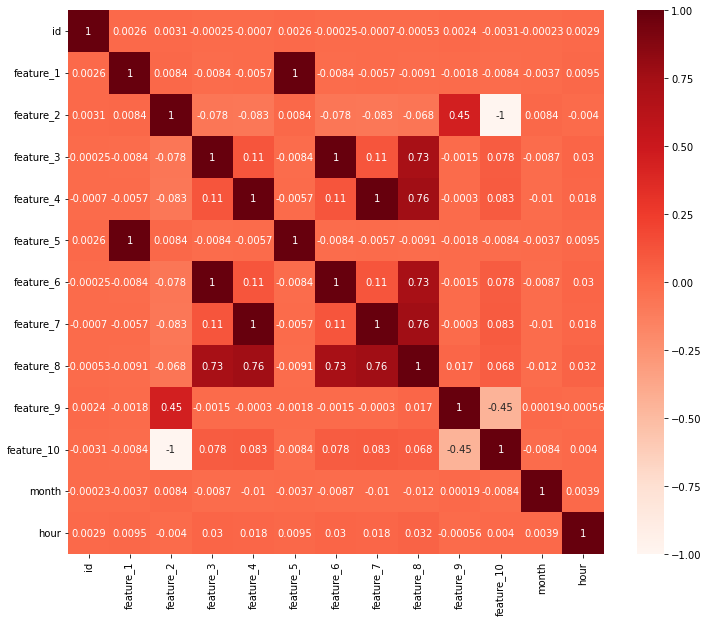

In [241]:
plt.figure(figsize=(12,10))
cor = df_training_X.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

## Observation
As we can see that feature 5 and feature 1 are perfectly correlated \
Feature 2 and feature 10 is perfectly inversely correlated \
Feature 3 and feature 6 is perfectly correlated \
Feature feature 4 and feature 7 is perfectly correlated \
Thus i will remove feature 5, 10, 6 and 7

In [242]:
#pop the duplicate feature for the training data
df_training_X.pop("id")
df_training_X.pop("feature_0")
df_training_X.pop("feature_5")
df_training_X.pop("feature_10")
df_training_X.pop("feature_6")
df_training_X.pop("feature_7")
df_training_X["label"] = Y
#pop the duplicate feature for the testing data
df_test_X.pop("feature_5")
df_test_X.pop("feature_10")
df_test_X.pop("feature_6")
df_test_X.pop("feature_7")
print( df_training_X.columns)

Index(['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_8',
       'feature_9', 'month', 'hour', 'label'],
      dtype='object')


Removing outliers

In [243]:
from scipy import stats
kf = KFold(n_splits = 5, shuffle = True)
kf_splitter = kf.split(df_training_X)


In [244]:
kf_result = next(kf_splitter, None)
train = df_training_X.iloc[kf_result[0]]
test =  df_training_X.iloc[kf_result[1]]
print(len(train.index))
print(len(test.index))
print(train.head())

320000
80000
   feature_1  feature_2  feature_3  feature_4  feature_8  feature_9  month  \
0          2       1.20        263        141     405.20   0.408689      1   
1          1       0.88        246         68     314.88  -0.256911      3   
2          3       7.61         24         13      44.61  56.880789      2   
3          1       1.50        239        163     403.50   1.218689      3   
4          1       1.20        142        229     372.20   0.408689      2   

   hour   label  
0    17   455.0  
1    17   413.0  
2    12  1501.0  
3    13   514.0  
4    18   605.0  


# process the first split

In [245]:
train = train[(np.abs(stats.zscore(df_training_X)) < 4).all(axis=1)]
print("we have removed", 320000 - len(train.index))

we have removed 3774


In [246]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [247]:
model_RidgeCV = Pipeline([("scaler", StandardScaler(with_mean=False)),("pca",PCA(n_components="mle")), ("regression", RidgeCV())])
#this is where the model changes 
Y = train.pop("label").to_numpy()
X = train.to_numpy()
model_RidgeCV.fit(X,Y)


Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                ('pca', PCA(n_components='mle')),
                ('regression', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))])

In [248]:
Y_test = test.pop("label").to_numpy()
X_test = test.to_numpy()
Y_hat = model_RidgeCV.predict(X_test)
print(f"Train error: {mean_absolute_error(Y_test, Y_hat)}")
print("the score is", model_RidgeCV.score(X_test,Y_test))

Train error: 410.3999642728436
the score is 0.020592385414444303


# Create a for loop that train for all splits

In [249]:
for splits in kf.split(df_training_X):
    train = df_training_X.iloc[splits[0]]
    test =  df_training_X.iloc[splits[1]]
    train = train[(np.abs(stats.zscore(df_training_X)) < 5).all(axis=1)] # first remove outliers
    print("we have removed", 320000 - len(train.index))
    model_RidgeCV = Pipeline([("scaler", StandardScaler(with_mean=False)),("pca",PCA(n_components="mle")), ("regression", RidgeCV())])
    #this is where the model changes 
    Y = train.pop("label").to_numpy()
    X = train.to_numpy()
    model_RidgeCV.fit(X,Y)
    # test the model
    Y_test = test.pop("label").to_numpy()
    X_test = test.to_numpy()
    Y_hat = model_RidgeCV.predict(X_test)
    print(f"Train error: {mean_absolute_error(Y_test, Y_hat)}")
    print("the score is", model_RidgeCV.score(X_test,Y_test))
    

we have removed 1199
Train error: 491.1300134161044
the score is -37.91568482147337
we have removed 1184
Train error: 416.5040659275494
the score is 0.018850033458763127
we have removed 1213
Train error: 390.01278859966715
the score is 0.023573485855386767
we have removed 1196
Train error: 406.85324116496395
the score is 0.018655620339697365
we have removed 1196
Train error: 410.9451849911641
the score is 0.02231449241922756


Base on the code and the training erro above, the method looks promising, now I will train the model with all the training data, and apply it to the test examples

# Apply the model to the test data for submission

In [250]:
#remove outliers
df_training_X = df_training_X[(np.abs(stats.zscore(df_training_X)) < 5).all(axis=1)]
#retrain the model
model_RidgeCV = Pipeline([("scaler", StandardScaler(with_mean=False)),("pca",PCA(n_components="mle")), ("regression", RidgeCV())])
Y = df_training_X.pop("label").to_numpy()
X = df_training_X.to_numpy()
model_RidgeCV.fit(X,Y)


Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                ('pca', PCA(n_components='mle')),
                ('regression', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))])

In [251]:
input_x = df_test_X.iloc[: , 2:] #remove id and feature 0 
print(input_x.columns) 
predicted_Y = model_RidgeCV.predict(input_x)
print(predicted_Y)
dict_pred = {'duration':predicted_Y}
df_pred = pd.DataFrame (dict_pred)
df_pred.index.name='id'
print(df_pred.head)
df_pred.to_csv('prediction.csv')  

Index(['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_8',
       'feature_9', 'month', 'hour'],
      dtype='object')
[ 445.74258399  557.46093012  673.33735714 ...  431.48377017 1316.20802659
 1381.65131866]
<bound method NDFrame.head of           duration
id                
0       445.742584
1       557.460930
2       673.337357
3       442.238546
4       944.411119
...            ...
99995   421.147480
99996   430.963276
99997   431.483770
99998  1316.208027
99999  1381.651319

[100000 rows x 1 columns]>
